Nolan Roth <br>
PHYS 434 AC

# Lab #7

In [49]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy import signal
from scipy.stats import norm
from astropy.table import QTable, Table, Column
from astropy import units as u
import numpy as np
import pickle
import h5py
import pandas as pd

plt.rcParams["figure.figsize"] = (20, 10)

In [50]:
infile = open ('higgs_250_500.pkl','rb')
higgs_data = pickle.load(infile)
infile = open ('qcd_250_500.pkl', 'rb')
qcd_data = pickle.load(infile)

In [51]:
higgs_data.keys()

Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')

## Problem 1

Making a stacked histogram for Higgs mass data versus QCD mass data: 

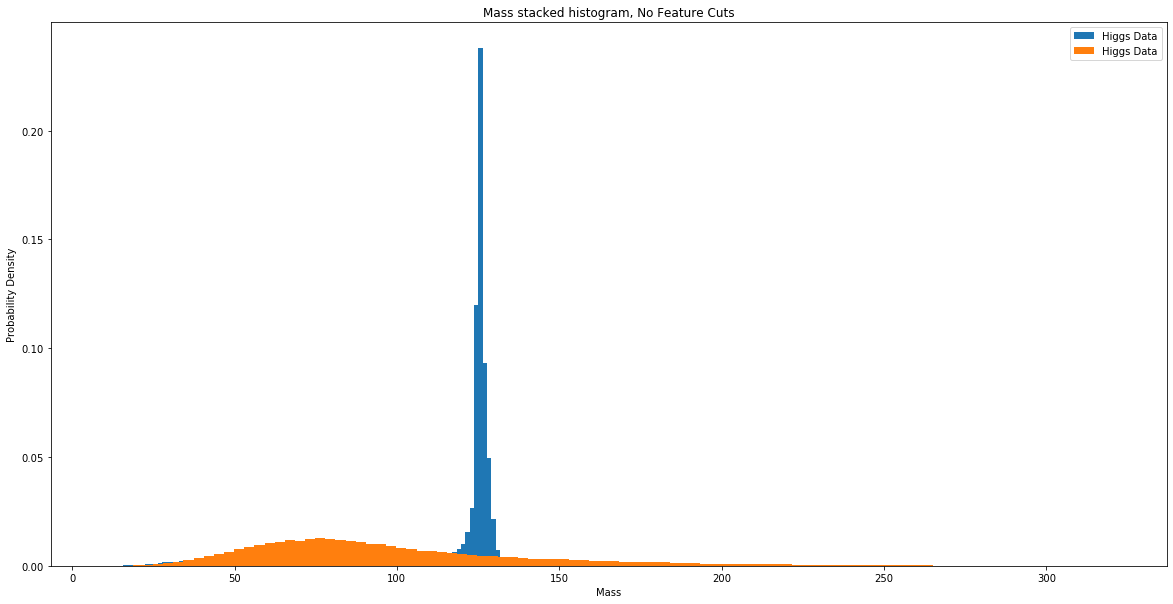

In [52]:
plt.hist(higgs_data['mass'], 100, density=True, label='Higgs Data')
plt.hist(qcd_data['mass'], 100, density=True, label='Higgs Data')
plt.title('Mass stacked histogram, No Feature Cuts')
plt.xlabel('Mass')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

In [53]:
higgs_temp = higgs_data['mass'].values
higgs_events = higgs_temp[0:len(higgs_temp)]
qcd_temp = qcd_data['mass'].values
qcd_events = qcd_temp[0:len(qcd_temp)]

Calculating the significance without any mass cuts:

In [54]:
total_events = len(higgs_events) + len(qcd_events)
normalized_higgs = 100
normalized_qcd = 20000
print('Significance without any cuts: ' + str(stats.norm.ppf(stats.poisson.cdf(normalized_higgs + normalized_qcd, normalized_qcd))))
print('N(Higgs) / sqrt(N(QCD)) = ' + str(normalized_higgs/(normalized_qcd)**(1/2)))

Significance without any cuts: 0.7112259282313185
N(Higgs) / sqrt(N(QCD)) = 0.7071067811865475


The significance value is very close to the value of N(Higgs) / sqrt(N(QCD)).

## Problem 2

In [57]:
def makeCut(lower, upper):
    cut_higgs_indices = []
    cut_qcd_indices = []
    # storing indices of data points with mass between upper and lower
    for i in range(0, len(higgs_events)):
        if higgs_events[i] >= lower and higgs_events[i] <= upper:
            cut_higgs_indices.append(i)
    for j in range(0, len(qcd_events)):
        if qcd_events[j] >= lower and qcd_events[j] <= upper:
            cut_qcd_indices.append(j)
    total_events = len(higgs_data['mass']) + len(qcd_data['mass'])
    normalized_higgs = 2 * 100 * (len(cut_higgs_indices) / total_events)
    normalized_qcd = 2 * 20000 * (len(cut_qcd_indices) / total_events)
    # multiplying the above values by 2 to account for the fact that when the counts are equal they
    # should be normalized to 100 and 20,000, not 50 and 10,000
    return [normalized_higgs, normalized_qcd, cut_higgs_indices, cut_qcd_indices]

Going forwards from 0 to 140 to find the optimal minimum for a mass cut:

In [58]:
max_sig = 0
max_lower = 0
for i in range(0, 140):
    x = makeCut(i, 140)
    higgs_count = x[0]
    qcd_count = x[1]
    sig = stats.norm.ppf(stats.poisson.cdf(higgs_count + qcd_count, qcd_count))
    if sig > max_sig:
        max_sig = sig
        max_lower = i
print(max_sig)
print(max_lower)

1.9323875707620133
123


Going backwards from 140 to 124 to find the optimal maximum for a mass cut:

In [59]:
max_sig = 0
max_upper = 140
for i in range(0, 140 - max_lower):
    x = makeCut(max_lower, 140 - i)
    higgs_count = x[0]
    qcd_count = x[1]
    sig = stats.norm.ppf(stats.poisson.cdf(higgs_count + qcd_count, qcd_count))
    if sig > max_sig:
        max_sig = sig
        max_upper = 140 - i
print(max_sig)
print(max_upper)

2.8645980478035016
128


So the optimal mass cut to maximize discovery significance is from 123 to 128.

In [60]:
temp = makeCut(123, 128)
mass_cut_higgs_indices = temp[2]
mass_cut_qcd_indices = temp[3]

## Problem 3

Stacked histograms for the rest of the variables:

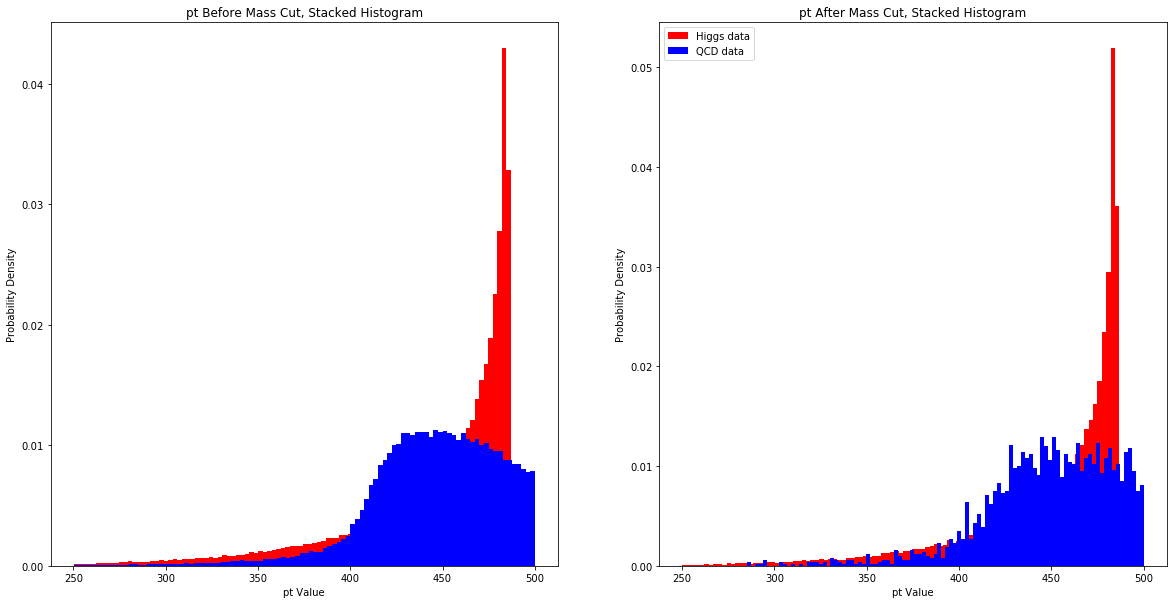

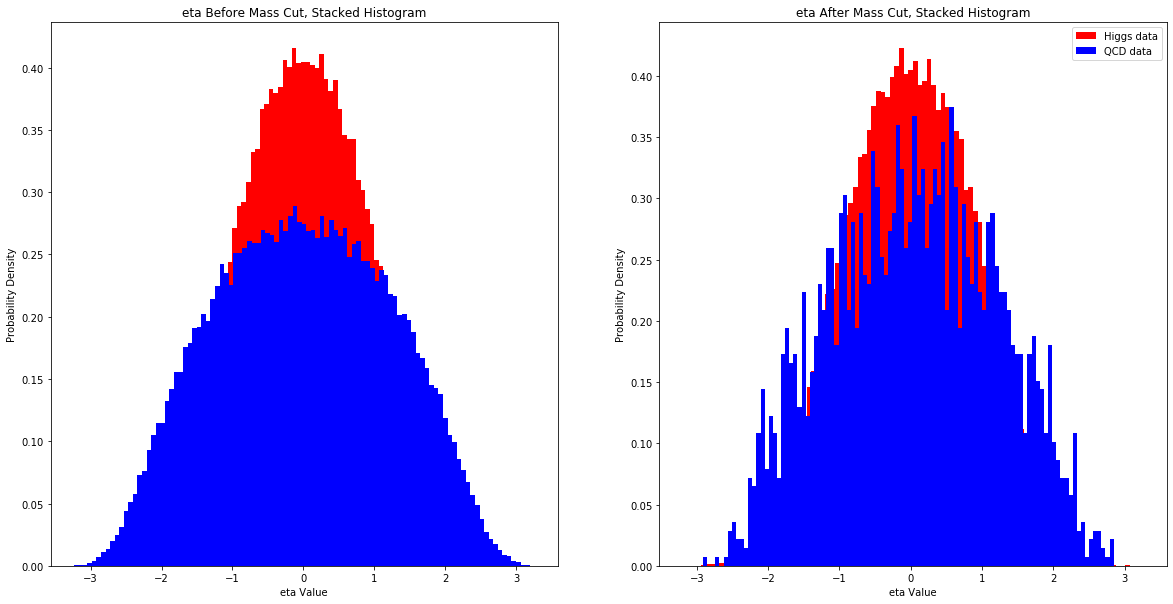

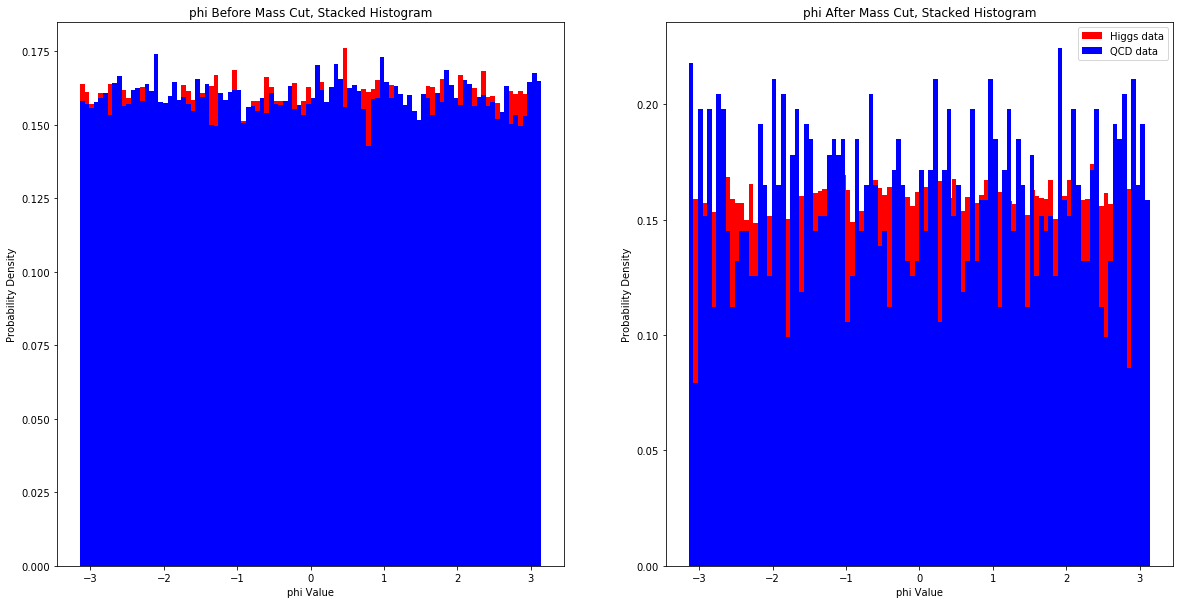

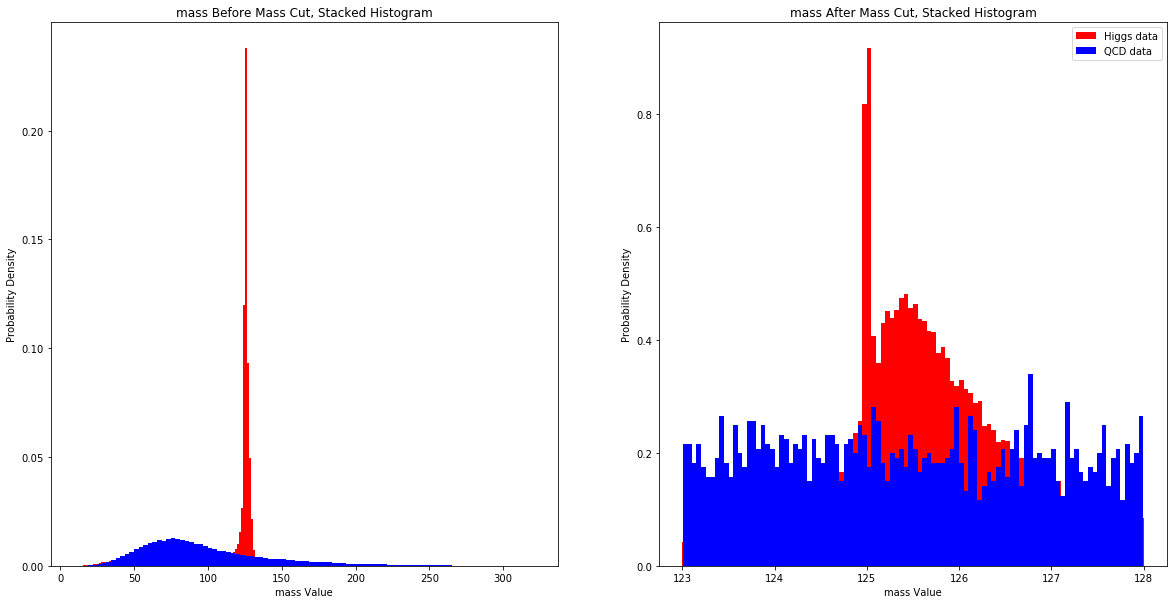

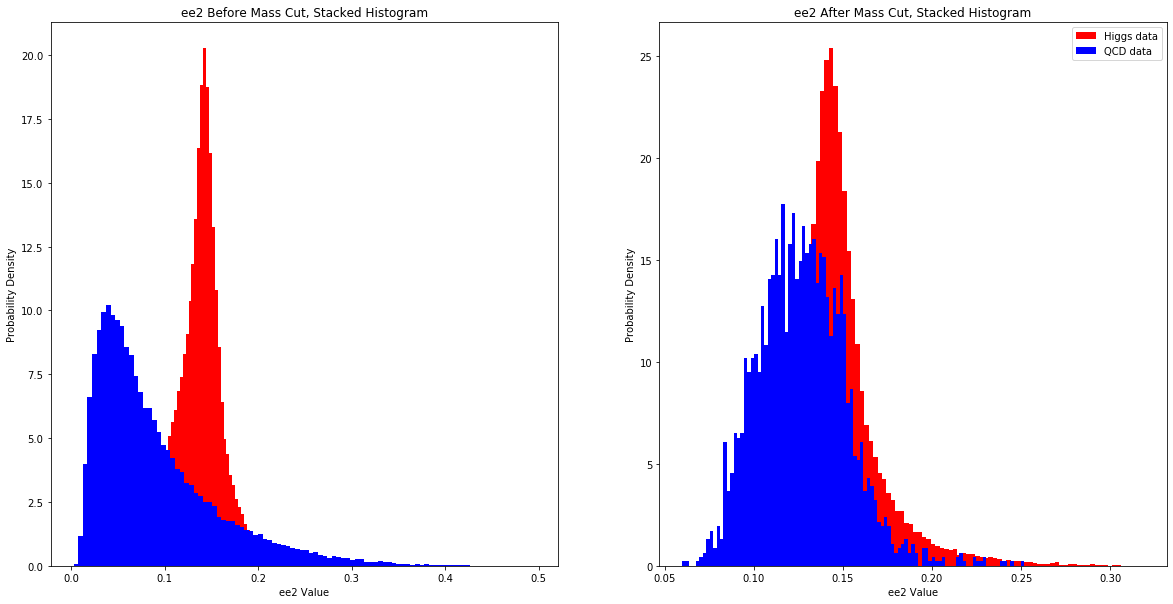

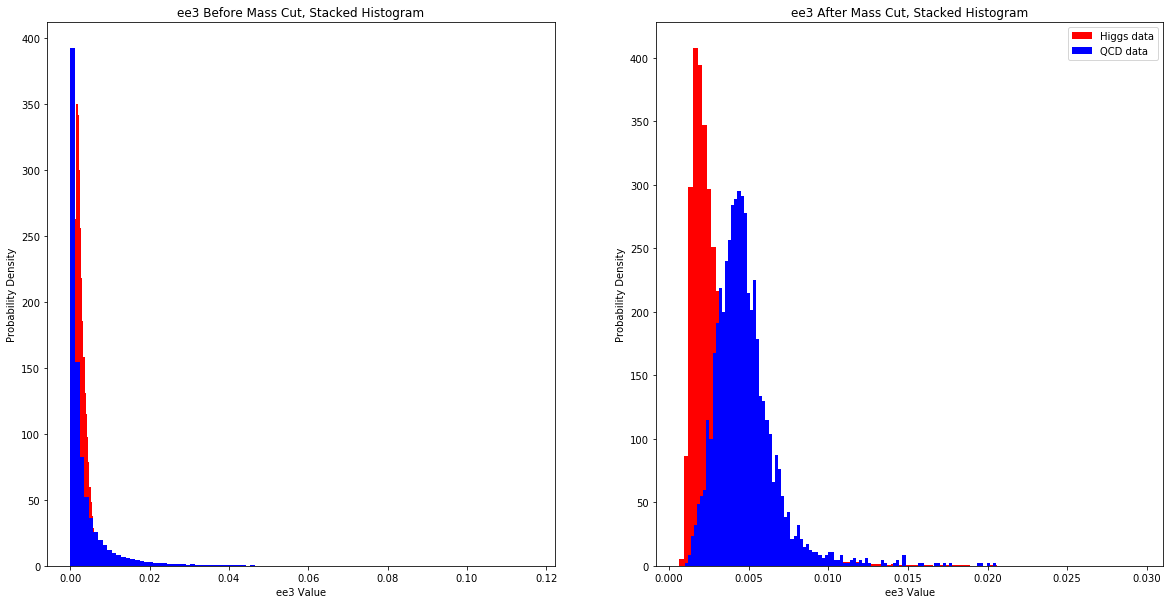

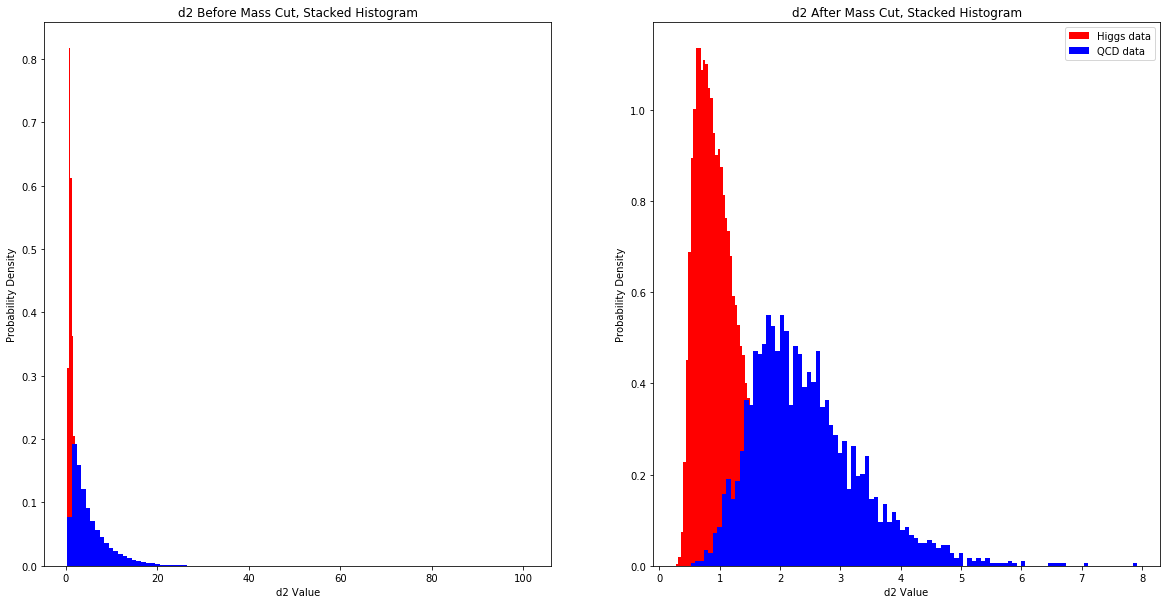

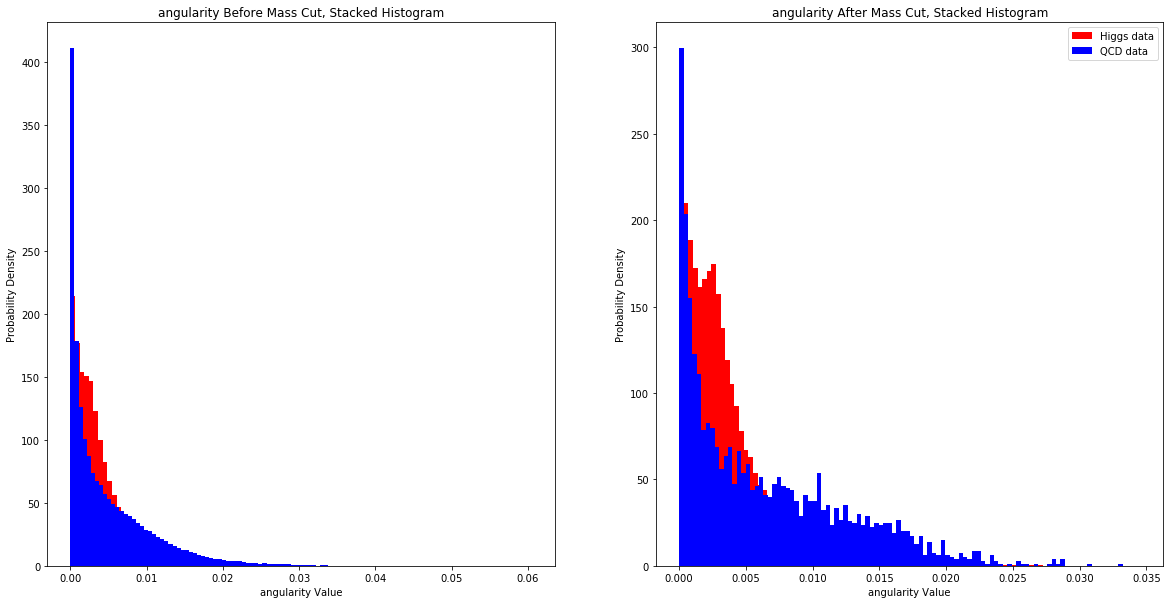

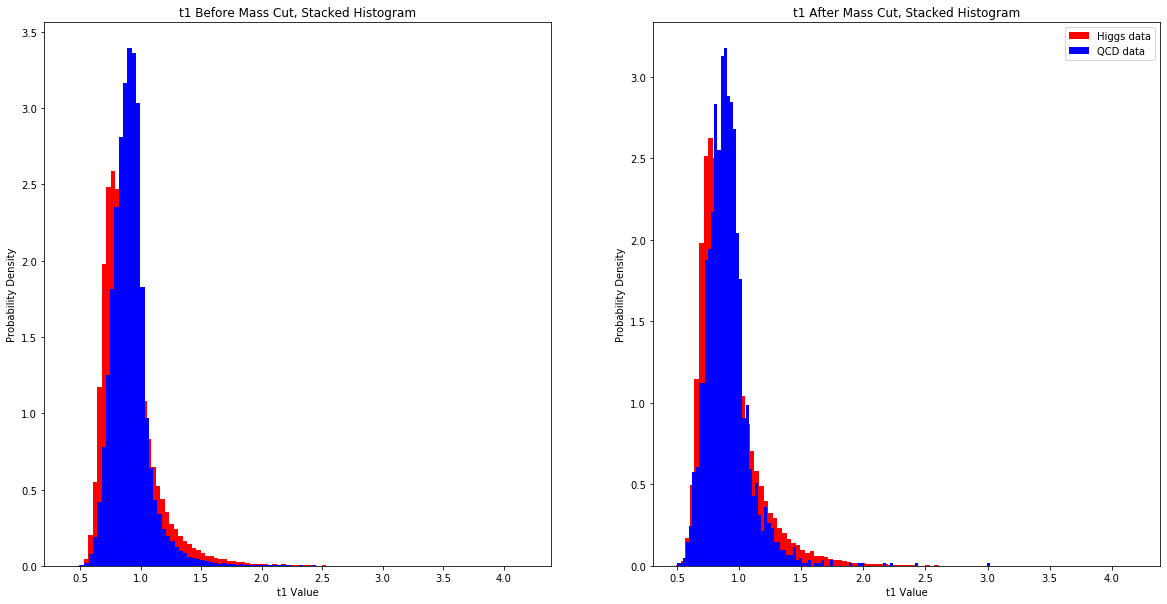

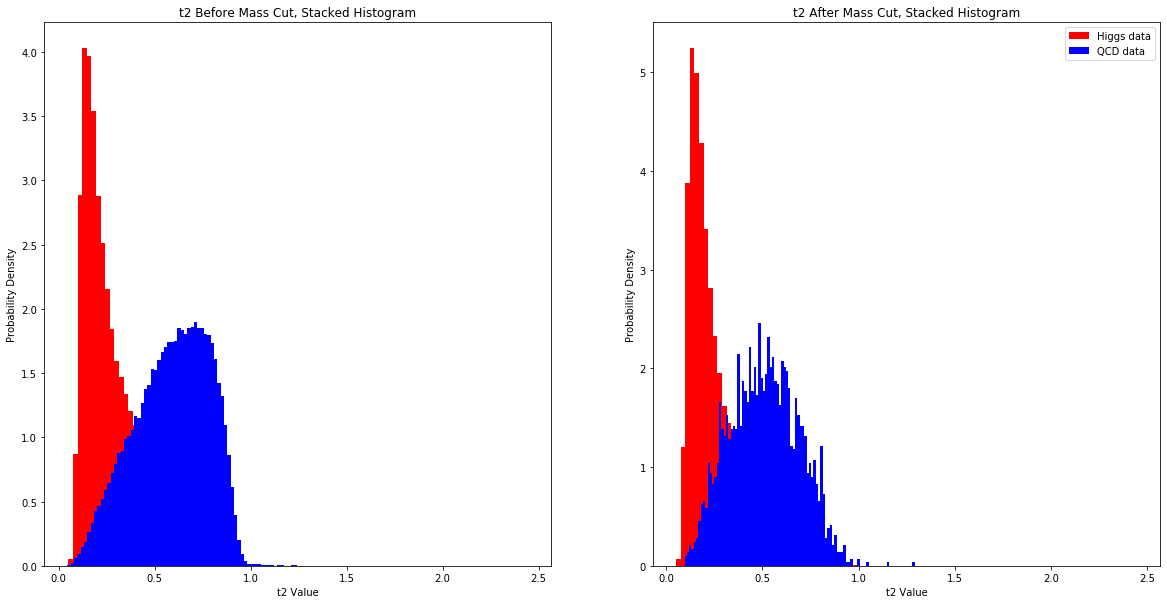

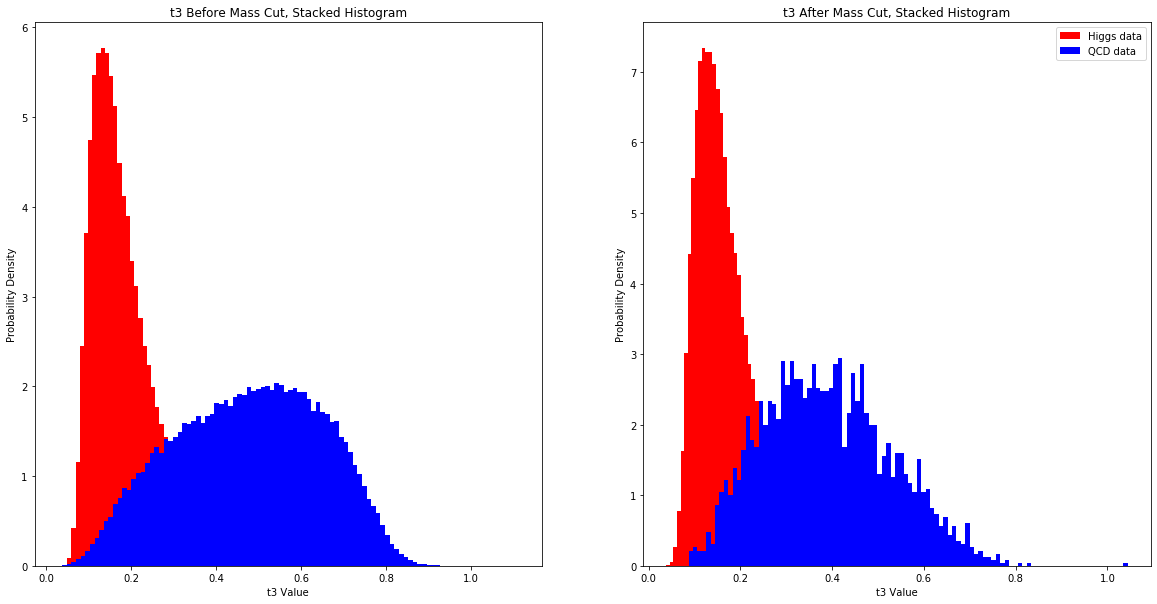

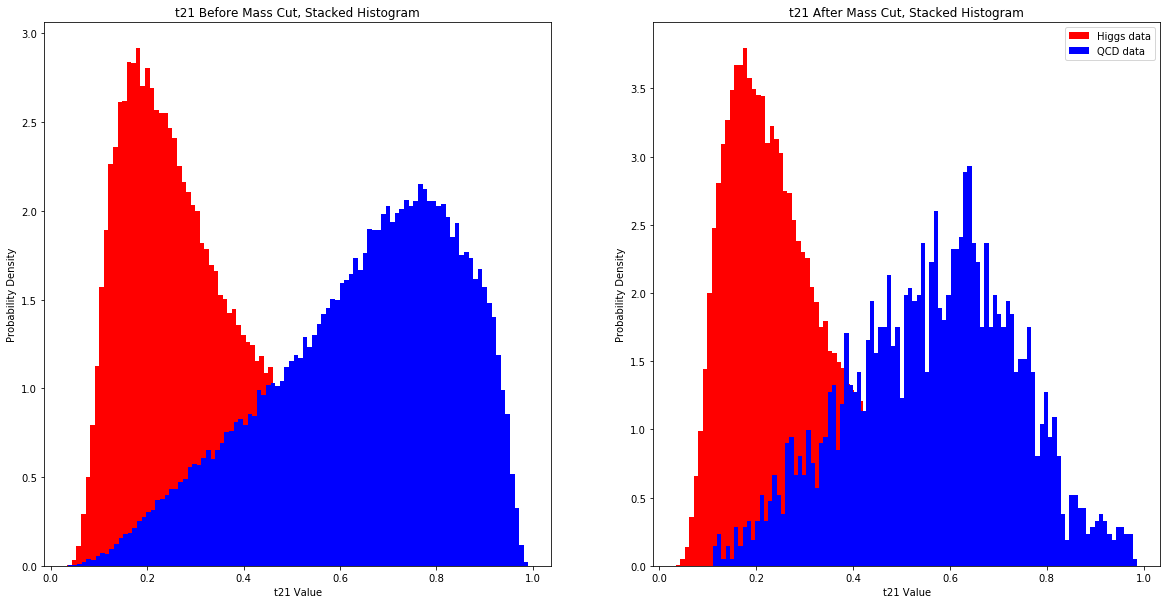

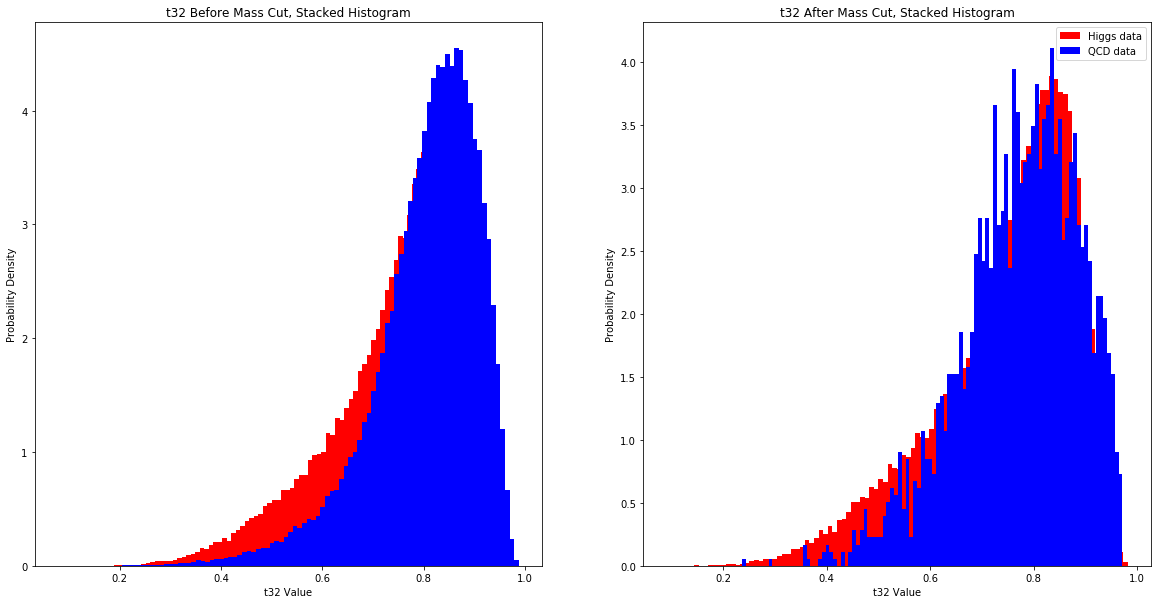

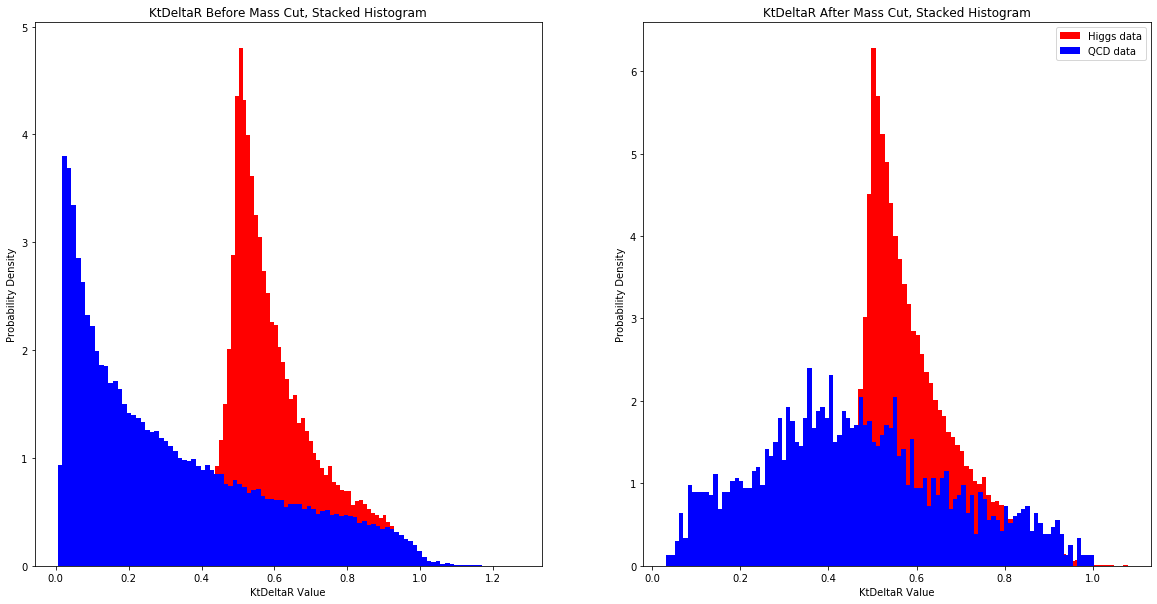

In [63]:
for key in higgs_data.keys():
    higgs_vals = higgs_data[key][mass_cut_higgs_indices]
    qcd_vals = qcd_data[key][mass_cut_qcd_indices]
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.hist(higgs_data[key], 100, density=True, color='r', label='Higgs data')
    ax1.hist(qcd_data[key], 100, density=True, color='b', label='QCD data')
    ax2.hist(higgs_vals, 100, density=True, color='r', label='Higgs data')
    ax2.hist(qcd_vals, 100, density=True, color='b', label='QCD data')
    ax1.set_title(str(key) + ' Before Mass Cut, Stacked Histogram')
    ax2.set_title(str(key) + ' After Mass Cut, Stacked Histogram')
    ax1.set_xlabel(str(key) + ' Value')
    ax2.set_xlabel(str(key) + ' Value')
    ax1.set_ylabel('Probability Density')
    ax2.set_ylabel('Probability Density')
    plt.legend()
    plt.show()

## Problem 4

In [124]:
def findLower(lower, upper):
    max_sig = 0
    max_lower = lower
    for i in np.arange(lower, upper, (upper - lower) / 20):
        higgs_count = makeCut(i, upper)[0]
        qcd_count = makeCut(i, upper)[1]
        sig = stats.norm.ppf(stats.poisson.cdf(higgs_count + qcd_count, qcd_count))
        if sig > max_sig and sig < 10000:
            max_sig = sig
            max_lower = i
    print(max_sig)
    print(max_lower)

In [126]:
def findUpper(lower, upper):
    max_sig = 0
    max_upper = upper
    for i in np.linspace(0.0, upper - lower, 20, endpoint=False):
        higgs_count = makeCut(lower, upper - i)[0]
        qcd_count = makeCut(lower, upper - i)[1]
        sig = stats.norm.ppf(stats.poisson.cdf(higgs_count + qcd_count, qcd_count))
        if sig > max_sig and sig < 10000:
            max_sig = sig
            max_upper = upper - i
    print(max_sig)
    print(max_upper)

Finding pt upper and lower bounds to maximize discovery significance:

In [145]:
higgs_temp = higgs_data['pt'][mass_cut_higgs_indices].values
higgs_events = higgs_temp[0:len(higgs_temp)]
qcd_temp = qcd_data['pt'][mass_cut_qcd_indices].values
qcd_events = qcd_temp[0:len(qcd_temp)]

In [146]:
findLower(450, 500)

2.600753426317833
457.5


In [147]:
findUpper(457.5, 500)

2.965624088208362
487.25


So optimal pt cut is from 457.5 to 487.25 with significance of 2.966$\sigma$.

In [148]:
higgs_temp = higgs_data['d2'][mass_cut_higgs_indices].values
higgs_events = higgs_temp[0:len(higgs_temp)]
qcd_temp = qcd_data['d2'][mass_cut_qcd_indices].values
qcd_events = qcd_temp[0:len(qcd_temp)]

In [149]:
findLower(0.0, 2.0)

4.406211934822533
0.0


In [150]:
findUpper(0.0, 2.0)

7.928367942870712
0.7


So the optimal d2 cut is from 0.0 to 0.7 with significance of 7.923$\sigma$.

Finding t3 upper and lower bounds to maximize discovery significance:

In [151]:
higgs_temp = higgs_data['t3'][mass_cut_higgs_indices].values
higgs_events = higgs_temp[0:len(higgs_temp)]
qcd_temp = qcd_data['t3'][mass_cut_qcd_indices].values
qcd_events = qcd_temp[0:len(qcd_temp)]

In [152]:
findLower(0.0, 1.0)

2.87390168626212
0.0


In [153]:
findUpper(0.0, 1.0)

7.162143256491439
0.1499999999999999


So optimal t3 cut is from 0.0 to 0.15 with significance of 7.162$\sigma$.

Finding t2 upper and lower bounds to maximize discovery significance:

In [154]:
higgs_temp = higgs_data['t2'][mass_cut_higgs_indices].values
higgs_events = higgs_temp[0:len(higgs_temp)]
qcd_temp = qcd_data['t2'][mass_cut_qcd_indices].values
qcd_events = qcd_temp[0:len(qcd_temp)]

In [155]:
findLower(0.0, 1.0)

2.858139403923798
0.0


In [156]:
findUpper(0.0, 1.0)

6.404059407884905
0.19999999999999996


So optimal t2 cut is from 0.0 to 0.2 with significance of 6.404$\sigma$.

Finding t21 upper and lower bounds to maximize discovery significance:

In [157]:
higgs_temp = higgs_data['t21'][mass_cut_higgs_indices].values
higgs_events = higgs_temp[0:len(higgs_temp)]
qcd_temp = qcd_data['t21'][mass_cut_qcd_indices].values
qcd_events = qcd_temp[0:len(qcd_temp)]

In [158]:
findLower(0.0, 0.6)

3.6864857581012083
0.0


In [159]:
findUpper(0.0, 0.6)

6.193815217225589
0.24


So optimal t21 cut is from 0.0 to 0.24 with significance of 6.194$\sigma$.

In [160]:
higgs_temp = higgs_data['KtDeltaR'][mass_cut_higgs_indices].values
higgs_events = higgs_temp[0:len(higgs_temp)]
qcd_temp = qcd_data['KtDeltaR'][mass_cut_qcd_indices].values
qcd_events = qcd_temp[0:len(qcd_temp)]

In [161]:
findLower(0.2, 0.8)

3.82524762183328
0.47000000000000003


In [162]:
findUpper(0.47, 0.8)

3.846429270855041
0.7505000000000001


So optimal KtDelta R cut is from 0.47 to 0.75 with significance of 3.846$\sigma$.

After testing multiple other feature cuts combined with the mass cut, the d2 feature provides the highest discrimination. When combining the mass cut of [123, 128] with the d2 cut of [0.0, 0.7], we get a discovery significance of 7.928$\sigma$.

# Lab #8

In [6]:
high_lumi_data = pd.read_hdf('data_highLumi_pt_250_500.h5')
low_lumi_data = pd.read_hdf('data_lowLumi_pt_250_500.h5')

In [7]:
high_lumi_data.keys()

Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')

In [8]:
low_lumi_data.keys()

Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')

## Problem 1

In [12]:
high_lumi_masses = np.array(high_lumi_data.get('mass'))
low_lumi_masses = np.array(low_lumi_data.get('mass'))

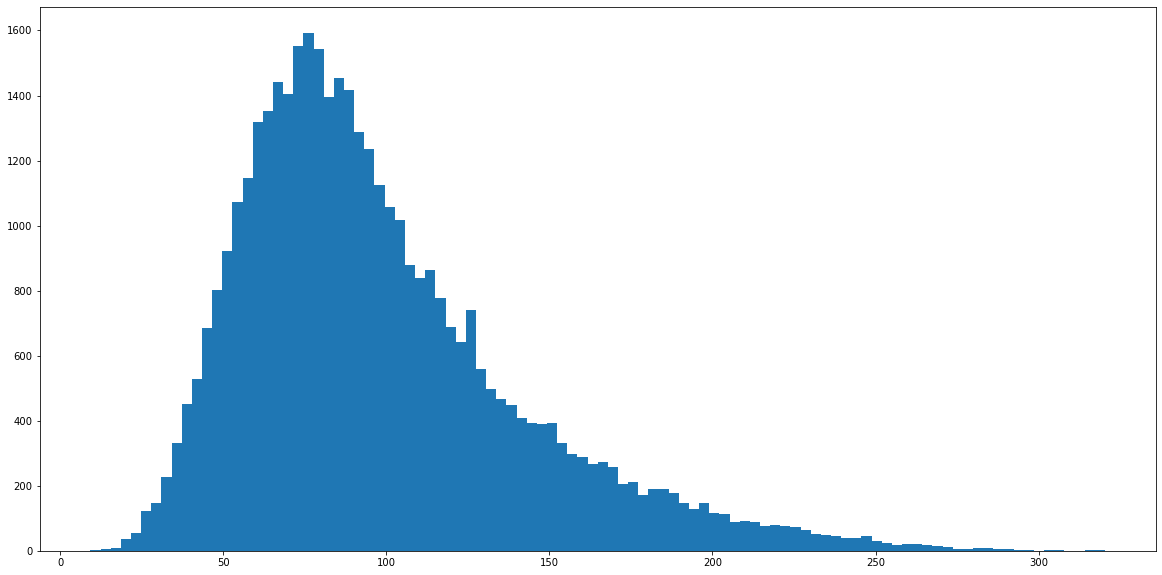

In [13]:
plt.hist(high_lumi_masses, 100, density=True)
plt.hist()
plt.show()

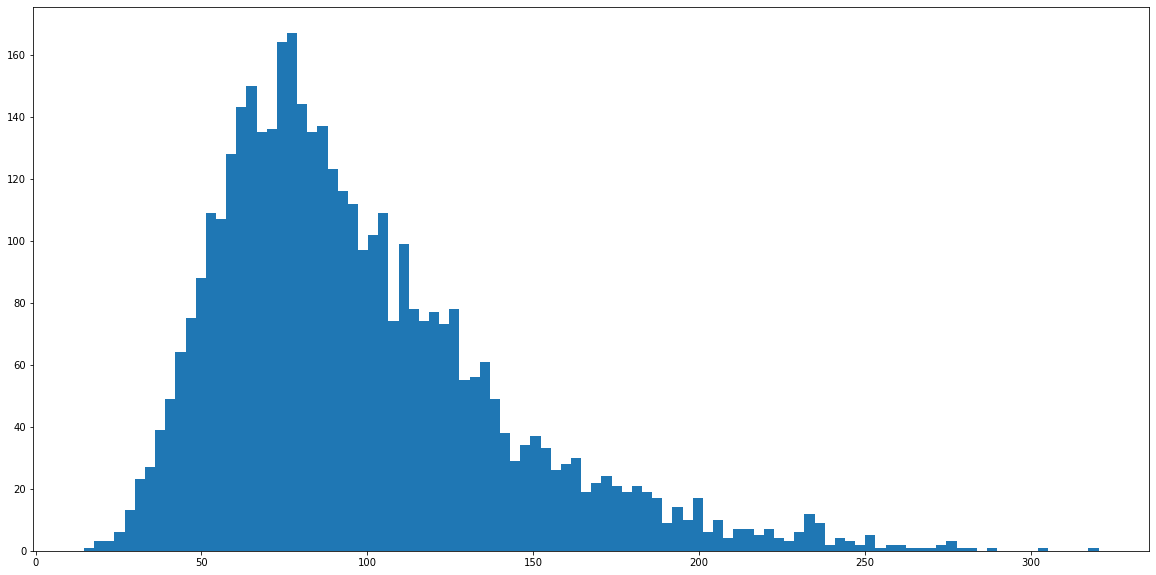

In [165]:
plt.hist(low_lumi_masses, 100)
plt.show()

In [14]:
def makeCut1(lower, upper, vals):
    cut_indices = []
    for i in range(0, len(vals)):
        if vals[i] >= lower and vals[i] <= upper:
            cut_indices.append(i)
    return cut_indices

In [57]:
mass_cut_high_indices = makeCut1(123, 128, high_lumi_masses)
high_cut_masses = high_lumi_masses[mass_cut_high_indices]
higgs_cut_masses = higgs_events[mass_cut_higgs_indices]
qcd_cut_masses = qcd_events[mass_cut_qcd_indices]

[125.89410185 125.00176204 124.66810799 ... 123.78531357 127.41069987
 125.64575417]


In [58]:
print(len(hi_cut_masses))
print(len(higgs_cut_masses))
print(len(qcd_cut_masses))

1122
63895
2412


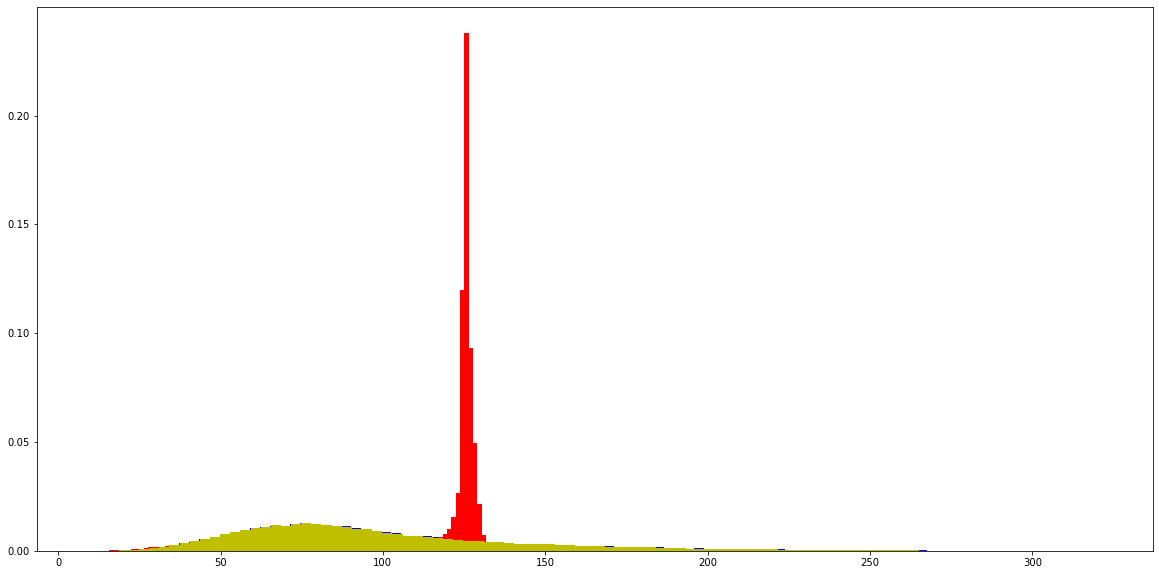

In [27]:
plt.hist(high_lumi_masses, 100, density=True, color='b')
plt.hist(higgs_data['mass'], 100, density=True, color='r')
plt.hist(qcd_data['mass'], 100, density=True, color='y')
plt.show()

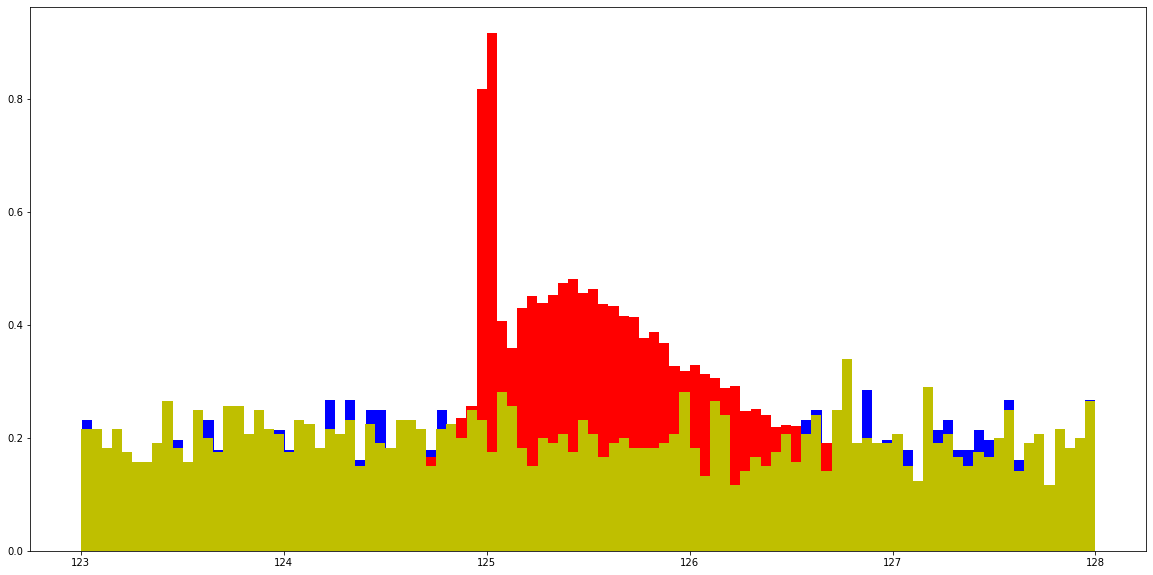

In [61]:
plt.hist(high_cut_masses, 100, density=True, color='b')
plt.hist(higgs_cut_masses, 100, density=True, color='r')
plt.hist(qcd_cut_masses, 100, density=True, color='y')
plt.show()